# About the dataset

Diabetes is a condition that carries an increased risk of developing eye complications. Diabetic eye disease includes complications such as diabetic retinopathy, cataracts and glaucoma.

Diabetes is the leading cause of blindness in working-age adults. People with type 1 and type 2 diabetes are at risk. It’s possible to be unaware that you have severe diabetic eye disease and suddenly go blind. Fortunately, most cases of blindness can be prevented with regular eye examinations and proper care.

The dataset consists of Normal, Diabetic Retinopathy, Cataract and Glaucoma retinal images where each class have approximately 1000 images. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc.

- Diabetic retinopathy:
The persistently high blood sugar levels that occur with diabetes can damage the retina’s small blood vessels (capillaries), which deliver oxygen and nutrients. Diabetic retinopathy affects up to a third of people with diabetes over the age of 502.

- Cataracts:
A cataract is a clouding of the lens in the eye. Left untreated, cataracts can eventually lead to blindness. People with diabetes are more likely to develop cataracts at an earlier age and suffer visual impairment faster than those without the condition.1,3

- Glaucoma:
This is a group of conditions that can damage the optic nerve. The optic nerve transmits signals from the retina to the brain for processing. Glaucoma is often (but not always) a result of increased pressure inside the eye. The risk of glaucoma in people with diabetes is significantly higher than that of the general population.1,4 The two main types are open-angle glaucoma (also called ‘the sneak thief of sight’) and angle-closure glaucoma (this comes on suddenly and is a medical emergency).

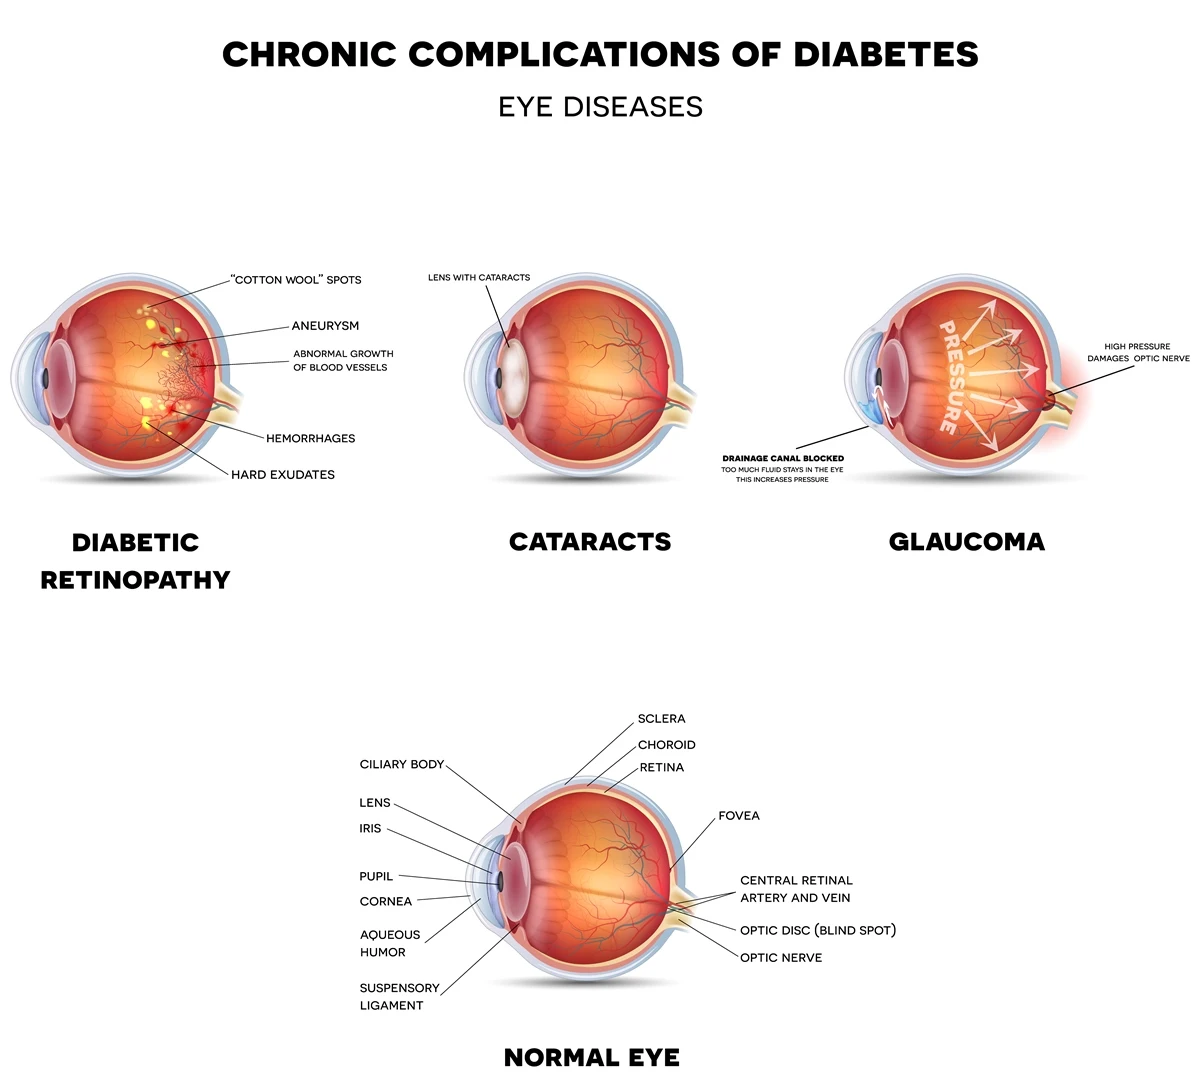

# About this notebook
#### In this notebook i will try to make a **comparison** between building and training a **nerual network from scratch** and using **Transfer learning(pretrained model)**, in terms of **trainig time, ease of creation, accuracy and consistancy**
#### This notebook was intented to be just a self trial to test the results, but i saw that it might help others so i tried to add insights and some references that might help

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
#!pip install visualkeras
import visualkeras
from sklearn.model_selection import KFold


# TensorFlow pipeline
We will create a dataset pipeline from our data using tensorflow dataset api

TensorFlow has a dataset api that supports writing descriptive and efficient input pipelines. a common pattern is to
- Create a source dataset from your input data.
- Apply dataset transformations to preprocess the data.
- Iterate over the dataset and process the elements.

[For more information](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [2]:
# generating dataset from directory

# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = 'C:\\Users\\jackaquamin\\Downloads\\BMEAppProject\\datasetKFold',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)


Found 4217 files belonging to 4 classes.


## Displaying data distribution

In [3]:
labels = np.concatenate([y for x,y in data], axis=0)

In [4]:
values = pd.value_counts(labels)
values = values.sort_index()

In [5]:
values

0    1038
1    1098
2    1007
3    1074
dtype: int64

### Checking labels

In [6]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = cataract, 1 = diabetic_retinopathy, 2 = glaucoma, 3 = normal, 

### The data is well distributed among the classes and is balanced

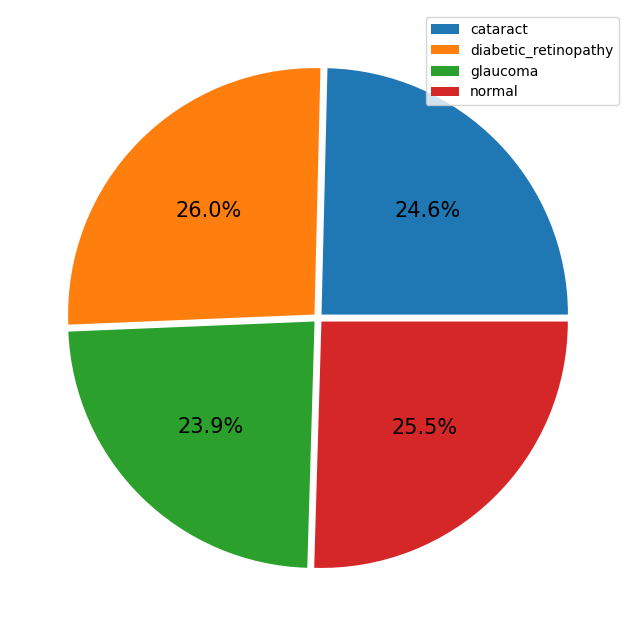

In [7]:
plt.figure(figsize=(12,8))
plt.pie(values,autopct='%1.1f%%', explode = [0.02,0.02,0.02, 0.02], textprops = {"fontsize":15})
plt.legend(labels=data.class_names)
plt.show()

## Getting a data generator to explore the data

In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

### Each batch contains 64 images, each image is 224x224

In [10]:
batch[0].shape

(64, 224, 224, 3)

## Displaying some images

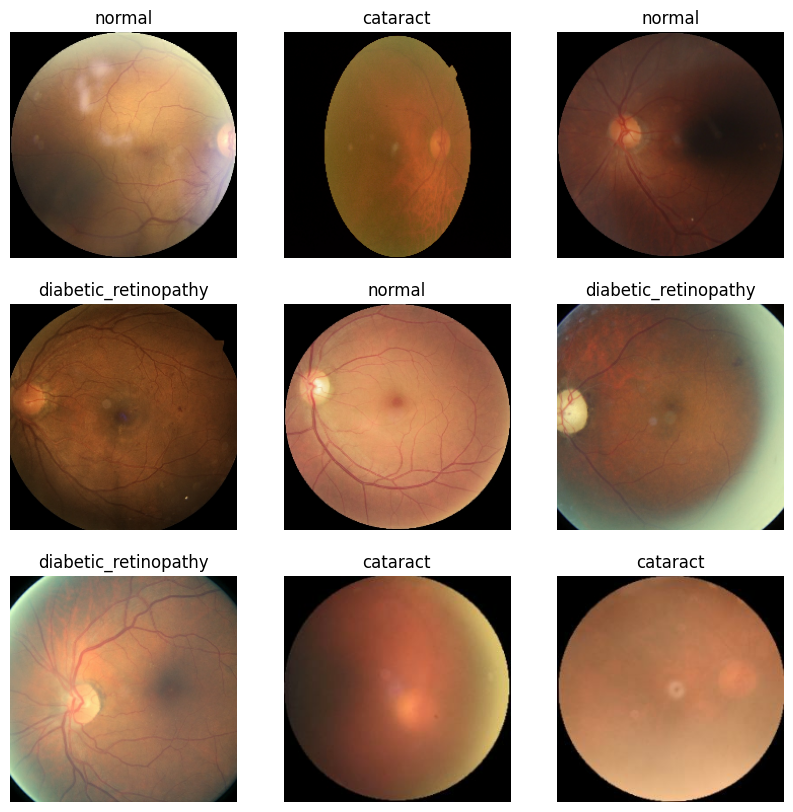

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

-----------
# Preprocessing images

## Standardize the data
Standardizing the data in image classification refers to the process of transforming the pixel values of images so that they have a mean of 0 and a standard deviation of 1. This normalization technique is also known as "Z-score normalization" or "standard score normalization." Standardization makes the data more amenable for training machine learning models, particularly neural networks, by ensuring that the features have similar scales and distributions.

In [12]:
data = data.map(lambda x, y: (x/255, y))

In [13]:
sample = data.as_numpy_iterator().next()

In [14]:
print(sample[0].min())
print(sample[0].max())

0.0
1.0


## Spliting the data

In [15]:
print("Total number of batchs = ",len(data))

Total number of batchs =  66


In [16]:
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [17]:
#train = data.take(train_size)
#remaining = data.skip(train_size)
#val = remaining.take(val_size)
#test = remaining.skip(val_size)

In [18]:
#print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}, # test batch = {len(test)}")
#len(train) + len(val) + len(test)

## Preparing test set

In [19]:
#test_iter = test.as_numpy_iterator()

In [20]:
#test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
#while True:
#  try:
#    batch = test_iter.next()
#    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
#    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
#  except:
#    break

In [21]:
data = data.shuffle(buffer_size=len(data), seed=2022, reshuffle_each_iteration=False)

In [22]:
kf = KFold(n_splits=5)
fold = 0

In [23]:
for train_index, val_index in kf.split(np.arange(len(data))):
    fold += 1
    print(f"Fold: {fold}")
    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size + val_size)

    test_iter = test.as_numpy_iterator()

    test_set = {"images": np.empty((0, 224, 224, 3)), "labels": np.empty(0)}
    while True:
        try:
            batch = test_iter.next()
            test_set['images'] = np.concatenate((test_set['images'], batch[0]))
            test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
        except:
            break

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5


In [24]:
y_true = test_set['labels']

------------
# CNN from scratch

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [26]:
# Displaying history loss/accuracy
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

-----------
# Transfer Learning (Pretrained Model)
#### **Here i will try to use a pretraind model, finetune it to fit our data, you can read [more about transfer learning here](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)**
#### **I used [EfficientNet](https://paperswithcode.com/method/efficientnet) pretrained model, because the data it was trained on is different from our data, i made the top level layers trainable to allow it to train, fit and adapt with our data**

In [27]:
from keras.applications import MobileNetV2
def make_model():
    mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')
    mobilenet.trainable = False

    
    for layer in mobilenet.layers[83:]:
      layer.trainable=True
    
    x = mobilenet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=2022)(x)        
    output=Dense(4, activation='softmax')(x)
    
    model= tf.keras.Model(inputs=mobilenet.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

In [28]:
model = make_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

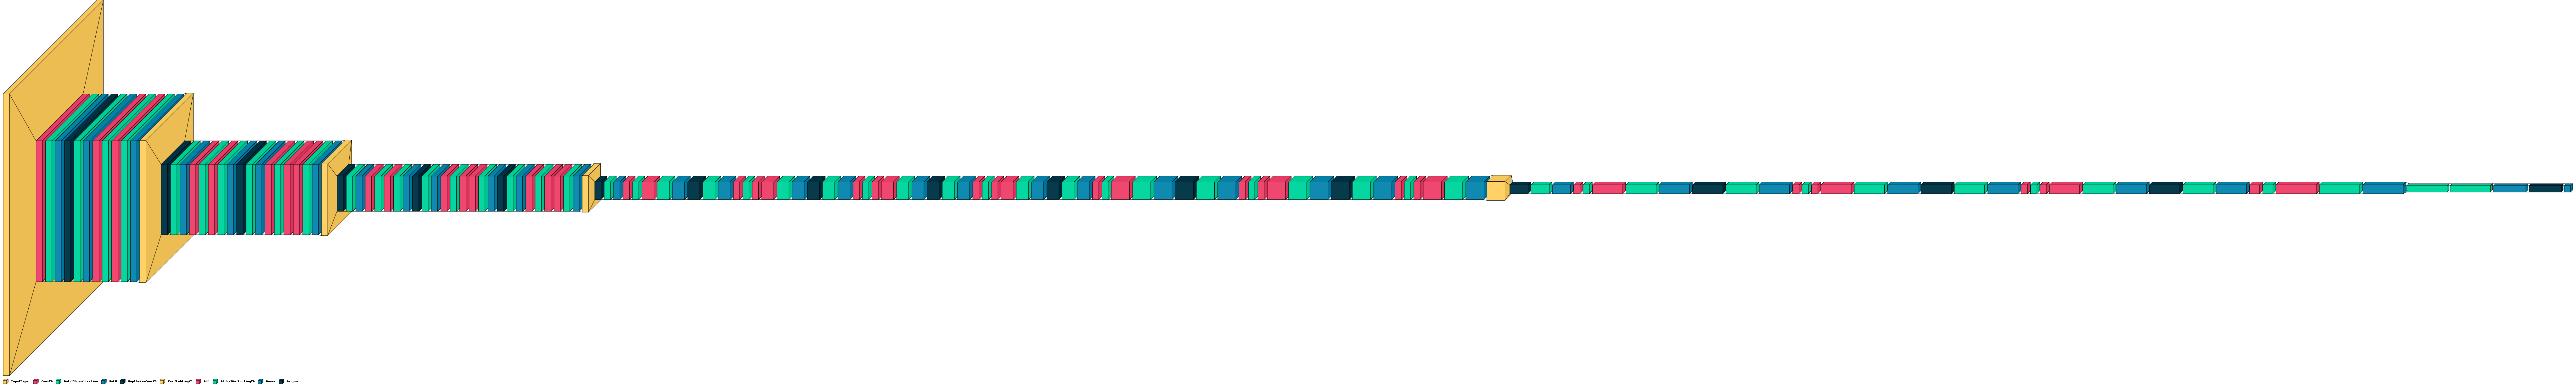

In [29]:
model.summary()

visualkeras.layered_view(model,legend=True)

## Train the Model

In [30]:
from keras import callbacks 
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=20,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 100,
    callbacks=[early_stop],
)

Epoch 1/100
47/47 [==============================] - 39s 522ms/step - loss: 16.8537 - accuracy: 0.8055 - val_loss: 17.0900 - val_accuracy: 0.2969
Epoch 2/100
47/47 [==============================] - 32s 506ms/step - loss: 10.1960 - accuracy: 0.9043 - val_loss: 10.8008 - val_accuracy: 0.4615
Epoch 3/100
47/47 [==============================] - 33s 519ms/step - loss: 6.6132 - accuracy: 0.9338 - val_loss: 6.9972 - val_accuracy: 0.4339
Epoch 4/100
47/47 [==============================] - 32s 508ms/step - loss: 4.4296 - accuracy: 0.9568 - val_loss: 5.3449 - val_accuracy: 0.4579
Epoch 5/100
47/47 [==============================] - 32s 509ms/step - loss: 3.0638 - accuracy: 0.9591 - val_loss: 3.9980 - val_accuracy: 0.5276
Epoch 6/100
47/47 [==============================] - 32s 510ms/step - loss: 2.1375 - accuracy: 0.9741 - val_loss: 2.8934 - val_accuracy: 0.5481
Epoch 7/100
47/47 [==============================] - 32s 507ms/step - loss: 1.5351 - accuracy: 0.9804 - val_loss: 2.0989 - val_accur

In [31]:
model_path = 'C:\\Users\\jackaquamin\\Downloads\\BMEAppProject\\model_kfold\\model_kfold2.h5'
model.save(model_path)

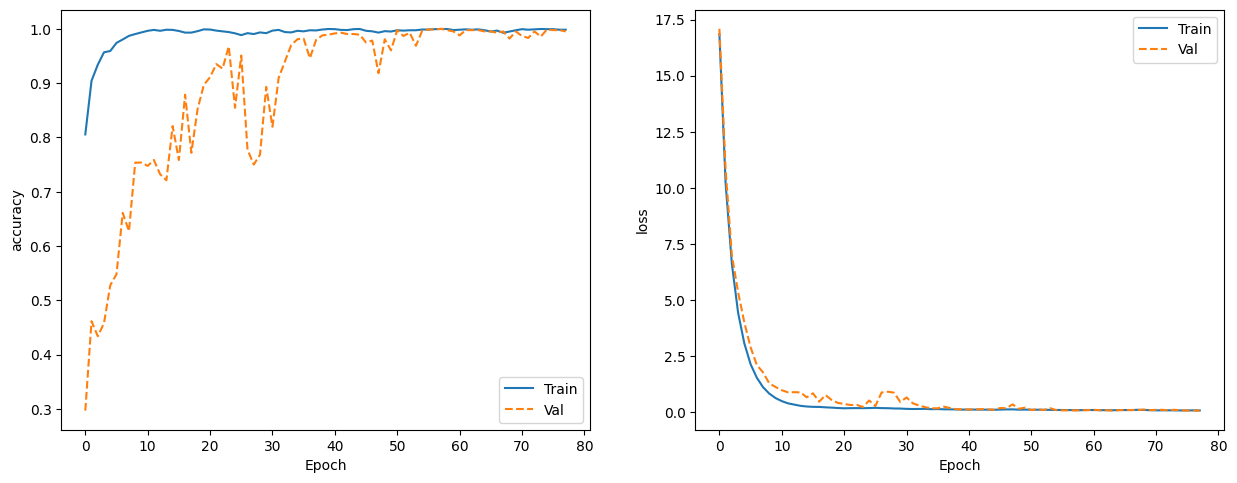

In [32]:
plot_his(history)

## Evaluating the model on test set

In [33]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

12/12 [==============================] - 3s 125ms/step


In [34]:
print(classification_report(y_true, y_pred, target_names = class_names))

                      precision    recall  f1-score   support

            cataract       1.00      1.00      1.00        96
diabetic_retinopathy       1.00      1.00      1.00        79
            glaucoma       1.00      1.00      1.00       113
              normal       1.00      1.00      1.00        89

            accuracy                           1.00       377
           macro avg       1.00      1.00      1.00       377
        weighted avg       1.00      1.00      1.00       377



Text(0.5, 1.0, 'Confusion Matrix')

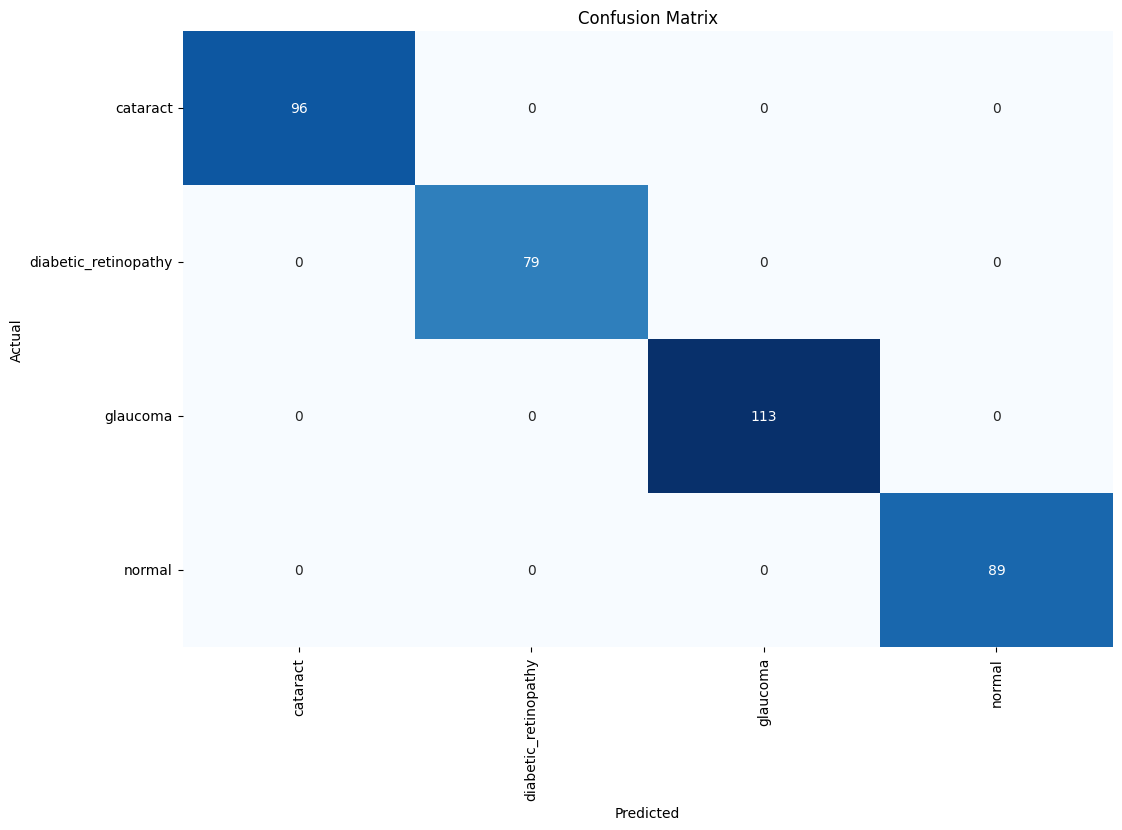

In [35]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(4)+.5, class_names, rotation=90)
plt.yticks(np.arange(4)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

## **Insights**
- The model acheived 95% accuracy and f1-score on the test set
- The training has run for 50 epochs and did not stop by early stopping, although noticing the history plot i don't think it could achieve any higher
- Each Epoch took about 50 sec to execute 
- The validation loss curve looks very smooth and has no fluctuations

# Conclusion
It's very intersting how transfer learning can improve and satisfy our goals with higher accuracy, consistant and faster
- With pretraind model We achieved 93% with 7% improvment from our own Neural network 86%
- The training phase was more consistant and faster in the pretraind model
- Maybe the Neural network i built wasn't the best and could be improved a lot, but you can see how easy and efficient you can use a pretrained model without the headaches of building you own layer by layer and trying to tune it as much as you can and you may not end with better result or close to as the pretrained one

So consider from now on to benfit from the power of Transfer learning and give it a try before trying to build your own one, it may save you a lot.

In [38]:
#import tensorflow.keras as keras

# load the model
''''model = keras.models.load_model('C:\\Users\\jackaquamin\\Downloads\\BMEAppProject\\model_kfold\\model_kfold.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_kfold.tflite', 'wb') as f:
    f.write(tflite_model) 

INFO:tensorflow:Assets written to: C:\Users\JACKAQ~1\AppData\Local\Temp\tmp1fckoz2j\assets


INFO:tensorflow:Assets written to: C:\Users\JACKAQ~1\AppData\Local\Temp\tmp1fckoz2j\assets
